### Inntak

Inntakið er stefnt net af Höfuðborgarsvæðinu, hver hnútur v táknar mót tveggja vega og
hefur auðkenni og staðsetningu, (x, y) hnit. Leggirnir (u, v) tákna vegi, þ.e. það er hægt að
keyra á frá u til v og á milli þessara hnúta er ekki hægt að taka neinar aðrar ákvarðanir í
umferðinni. Skráin nodes inniheldur upplýsingar um hnútana, edges inniheldur upplýsingar um vegina.

### Reiknirit

Ef við fáum gefinn lista af k hnútum þar sem settar hafa verið upp hleðslustöðvar, búið til
reiknirit sem reiknar stystu fjarlægð frá hnverjum hnúti v í einhverja hleðslustöð. Fjarlægðir
á leggjum eiga að vera mældar í metrum og þær eru reiknaðar út frá hnitum hnútanna.
Einfaldasta leiðin til að leysa þetta er að nota reiknirit dijkstra fyrir hverja hleðslustöð
en það er hægt að hraða því með því að setja upphafsfjarlægðirnar á skynsamlegan hátt.

## Verkþættir

### 1. Þáttun (⋆)

Lesið inn netið úr skránum sem eru gefnar, nodes.tsv og edges.tsv. Í skránni nodes.tsv
eru hnútar með auðkenni (id), hnit (x, y) og hvort þeir séu á aðalvegi (primary). Í skránni
edges.tsv eru leggi frá hnúti u til hnúts v með lengd length, mæld í metrum, og nafn
(name).

In [1]:
import pandas as pd

In [2]:
nodes = pd.read_csv("nodes.tsv", sep="\t")
edges = pd.read_csv("edges.tsv", sep="\t")

In [ ]:
import networkx as nx

# fall sem býr til net
def make_graph(nodes, edges):
    """Býr til nx.DiGraph með gefnum nodes og edges"""

    # Búum til stefnt net
    G = nx.DiGraph()

    # Bætum við hnútum
    for _, row in nodes.iterrows():
        G.add_node(row["osmid"], x=row["x"], y=row["y"], primary=row["primary"])

    # Bætum við leggjum
    for _, row in edges.iterrows():
        G.add_edge(row["u"], row["v"], weight=row["length"])
    
    return G 


In [46]:
def create_graph_dict(nodes, edges):
    """
    Creates a graph dictionary from nodes and edges DataFrames.

    Parameters:
    - nodes: DataFrame containing node information.
    - edges: DataFrame containing edge information.

    Returns:
    - graph: Dictionary representing the graph.
    """
    # Initialize an empty dictionary for the graph
    graph = {node_id: {} for node_id in nodes["osmid"]}

    # Populate the graph with edges
    for _, row in edges.iterrows():
        u = row["u"]  # Source node
        v = row["v"]  # Target node
        weight = row["length"]  # Edge weight
        graph[u][v] = weight

    return graph

In [38]:
# Búum til net með gefnum nodes og edges
G = make_graph(nodes, edges)

# create a smaller graph for testing
small_nodes = nodes[nodes["osmid"].isin([252743977, 252744017, 252744019, 252744020, 252744087, 252744169, 252744265, 252744269, 252744311, 252744761, 10799990340, 10799990350, 837627438, 1194972614, 10799990319, 10799990311, 837627420, 837627414, 837627410, 8585855191, 1194973102])]

pos = {row["osmid"]: (row["x"], row["y"]) for _, row in small_nodes.iterrows()}

filtered_edges = edges[
            edges["u"].isin(pos.keys()) & edges["v"].isin(pos.keys())
]
G_small = make_graph(small_nodes, filtered_edges) 

print(G_small)


DiGraph with 21 nodes and 38 edges


In [47]:
G_small_dict = create_graph_dict(small_nodes, filtered_edges)
print(G_small_dict)

{252743977: {10799990340: 11.166247287788131, 10799990350: 31.676114024679695}, 252744017: {252744761: 36.45911409065883, 252744169: 116.91047923722422, 252744019: 61.7120569183292}, 252744019: {252744020: 47.37947782346877, 837627438: 45.570294770686935, 252744017: 61.7120569183292}, 252744020: {252744019: 47.37947782346877}, 252744087: {1194972614: 33.01112627463227, 10799990319: 11.314953109531311}, 252744169: {10799990311: 10.182186591756205, 252744017: 116.91047923722422, 252744265: 196.18408969547883}, 252744265: {252744269: 139.64964990481604, 252744169: 196.1840896954789, 837627420: 88.80142636069803}, 252744269: {837627414: 147.38608464875284, 252744265: 139.64964990481607, 252744311: 69.30303181583486}, 252744311: {837627410: 420.6498541177572, 252744269: 69.30303181583486, 8585855191: 142.57439488797942}, 252744761: {252744017: 36.45911409065883, 1194973102: 351.33322227161443, 837627414: 158.34728019618612}, 837627410: {252744311: 420.6498541177571}, 837627414: {252744269: 

### 2. Leit (⋆⋆)

Ef við setjum hleðslustöðvar á hnúta v1, . . . , vk þá er hægt að nota reikniritið dijkstra til að finna stystu fjarlægð frá hverjum hnúti u í hleðslustöð vi. Útfærið reikniritið sem tekur inn lista af lokahnútum og reiknar fjarlægðir frá öllum hnútum í netinu. 
Athugið að netið er stefnt net.

In [90]:
import heapq

def reverse_graph(graph):
    reversed_graph = {node: {} for node in graph}
    for u in graph:
        for v, w in graph[u].items():
            if v not in reversed_graph:
                reversed_graph[v] = {}
            reversed_graph[v][u] = w
    return reversed_graph

def dijkstra(graph, start):
    queue = [(0, start)]
    distances = {node: float('inf') for node in graph}
    previous = {node: None for node in graph}
    distances[start] = 0

    while queue:
        current_dist, current_node = heapq.heappop(queue)
        if current_dist > distances[current_node]:
            continue

        for neighbor, weight in graph[current_node].items():
            distance = current_dist + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous[neighbor] = current_node
                heapq.heappush(queue, (distance, neighbor))

    return distances, previous

def reconstruct_path(previous, start, end):
    path = []
    current = start
    while current != end and current is not None:
        path.append(current)
        current = previous[current]
    if current == end:
        path.append(end)
        path.reverse()
        return path
    return []  # no path found


def shortest_paths_to_all_stations(graph, destination_nodes):
    reversed_graph = reverse_graph(graph)
    results = {}  # {node: {dest: (distance, path)}}

    for dest in destination_nodes:
        distances, previous = dijkstra(reversed_graph, dest)

        for node in distances:
            if node not in results:
                results[node] = {}
            dist = distances[node]
            path = reconstruct_path(previous, node, dest)
            results[node][dest] = (dist, path)

    return results

In [94]:
distances, prev = dijkstra(G_small_dict, 252743977)
print("Distances from 252743977:")
for node, dist in distances.items():
    print(f"Node {node}: {dist}")

Distances from 252743977:
Node 252743977: 0
Node 252744017: 192.5620575108232
Node 252744019: 254.2741144291524
Node 252744020: 301.6535922526212
Node 252744087: 19.825161182635746
Node 252744169: 75.65157827359897
Node 252744265: 271.8356679690778
Node 252744269: 411.48531787389385
Node 252744311: 480.7883496897287
Node 252744761: 229.02117160148202
Node 837627410: 901.4382038074859
Node 837627414: 387.3684517976682
Node 837627420: 360.63709432977583
Node 837627438: 299.84440919983933
Node 1194972614: 52.836287457268014
Node 1194973102: 580.3543938730965
Node 8585855191: 623.3627445777081
Node 10799990311: 85.83376486535518
Node 10799990319: 31.140114292167056
Node 10799990340: 11.166247287788131
Node 10799990350: 31.676114024679695


In [91]:
reversed_graph = reverse_graph(G_small_dict)

destination_nodes = [10799990350, 252743977]

results = shortest_paths_to_all_stations(G_small_dict, destination_nodes)

for node in sorted(results.keys()):
    for dest in destination_nodes:
        dist, path = results[node].get(dest, (float('inf'), []))
        print(f"From {node} to {dest}:")
        print(f"  Distance: {dist}")
        print(f"  Path: {path}")
    

From 252743977 to 10799990350:
  Distance: 31.676114024679695
  Path: [10799990350, 252743977]
From 252743977 to 252743977:
  Distance: 0
  Path: [252743977]
From 252744017 to 10799990350:
  Distance: 171.29704390890552
  Path: [10799990350, 10799990311, 252744169, 252744017]
From 252744017 to 252743977:
  Distance: 159.4885238826471
  Path: [252743977, 10799990311, 252744169, 252744017]
From 252744019 to 10799990350:
  Distance: 233.00910082723473
  Path: [10799990350, 10799990311, 252744169, 252744017, 252744019]
From 252744019 to 252743977:
  Distance: 221.2005808009763
  Path: [252743977, 10799990311, 252744169, 252744017, 252744019]
From 252744020 to 10799990350:
  Distance: 280.3885786507035
  Path: [10799990350, 10799990311, 252744169, 252744017, 252744019, 252744020]
From 252744020 to 252743977:
  Distance: 268.5800586244451
  Path: [252743977, 10799990311, 252744169, 252744017, 252744019, 252744020]
From 252744087 to 10799990350:
  Distance: 52.54904889842255
  Path: [10799990

In [93]:
import folium

# Create a Folium map centered on the average location of the nodes
map_center = [small_nodes["y"].mean(), small_nodes["x"].mean()]
folium_map = folium.Map(location=map_center, zoom_start=15)

# Helper: get coordinates from node ID
node_coords = nodes.set_index('osmid')[['y', 'x']].to_dict('index')  # {osmid: {'y': lat, 'x': lon}}

def node_id_to_coords(node_id):
    if node_id in node_coords:
        return [node_coords[node_id]['y'], node_coords[node_id]['x']]  # [lat, lon]
    return None

destination = 10799990350

for start_node, dests in results.items():
    if destination not in dests:
        continue
    dist, path = dests[destination]
    if dist == float('inf') or not path:
        continue

    coords = [node_id_to_coords(n) for n in path if node_id_to_coords(n)]
    
    # Add a polyline for this path
    folium.PolyLine(coords, color='blue', weight=2, opacity=0.6).add_to(folium_map)

# Add markers for the destination
dest_coord = node_id_to_coords(destination)
folium.Marker(dest_coord, popup=f"Destination {destination}", icon=folium.Icon(color='red')).add_to(folium_map)

folium_map


In [ ]:
def shortest_path_to_charging_station(G, charging_stations):

    """ Reiknirit sem reiknar stystu leið frá öllum hnútum í netinu til hleðslustöðvanna
     
        Inntak:
        G: stefnt net
        charging_station: listi af lokahnútum sem eru hleðslustöðvar

        Úttak:
        G: Stefnt net sem inniheldur stystu leiðirnar frá öllum hnútum í netinu til hleðslustöðvanna
    """

    # Listi til að geyma niðurstöður
    results = []

    # Reiknum stystu leiðir frá hverjum hnút í netinu til allra hleðslustöðva
    for node in G.nodes():
        for cs in charging_stations:
            if nx.has_path(G, node, cs):  # Athugum hvort leið sé til hleðslustöðvar
                distance = nx.shortest_path_length(G, source=node, target=cs, weight="weight")
                results.append({"start_node": node, "charging_station": cs, "distance": distance})
            else:
                results.append({"start_node": node, "charging_station": cs, "distance": float("inf")})  # Engin leið

    # Skilum niðurstöðum sem DataFrame
    return pd.DataFrame(results)



Hraðari útfærsla:

In [5]:
def shortest_path_to_charging_station_faster(nodes, edges, charging_stations, start_nodes):
    """Reiknirit sem reiknar stystu leið frá ákveðnum hnútum í netinu til hleðslustöðvanna."""
    
    # Búum til stefnt net
    G = nx.DiGraph()

    # Bætum við hnútum
    for _, row in nodes.iterrows():
        G.add_node(row["osmid"], x=row["x"], y=row["y"], primary=row["primary"])

    # Bætum við leggjum
    for _, row in edges.iterrows():
        G.add_edge(row["u"], row["v"], weight=row["length"])

    # Reverse the graph to calculate shortest paths from charging stations to all nodes
    G_reversed = G.reverse()

    # Use multi-source Dijkstra's algorithm from all charging stations
    distances = nx.multi_source_dijkstra_path_length(G_reversed, sources=charging_stations, weight="weight")

    # Collect results for the specified start nodes
    results = []
    for node in start_nodes:
        for cs in charging_stations:
            distance = distances.get(node, float("inf"))  # Get distance or infinity if unreachable
            results.append({"start_node": node, "charging_station": cs, "distance": distance})

    return pd.DataFrame(results)

### 3. Framsetning (⋆)

Setjið fimm hleðslustöðvar í netið og sýnið stystu leið fyrir fimm punkta og teiknið upp á kort. Tékkið ykkur af með því að bera saman leiðina sem er fundin og fjarlægðina miðað við kortavefi eins og t.d. Google Maps.

In [6]:
import matplotlib.pyplot as plt

In [10]:
# Veljum fimm hnúta þar sem við setjum hleðslustöð
charging_stations = [12885876, 111456955, 14586813, 26471955, 34187360]

# fimm hnútar sem við veljum
five_nodes = [34389202, 35295068, 253467906, 330050169, 27237169]

shortest_path_five = shortest_path_to_charging_station_faster(nodes, edges, charging_stations, five_nodes)

shortest_path_five.head()


,start_node,charging_station,distance
0,34389202,12885876,2291.52577
1,34389202,111456955,2291.52577
2,34389202,14586813,2291.52577
3,34389202,26471955,2291.52577
4,34389202,34187360,2291.52577


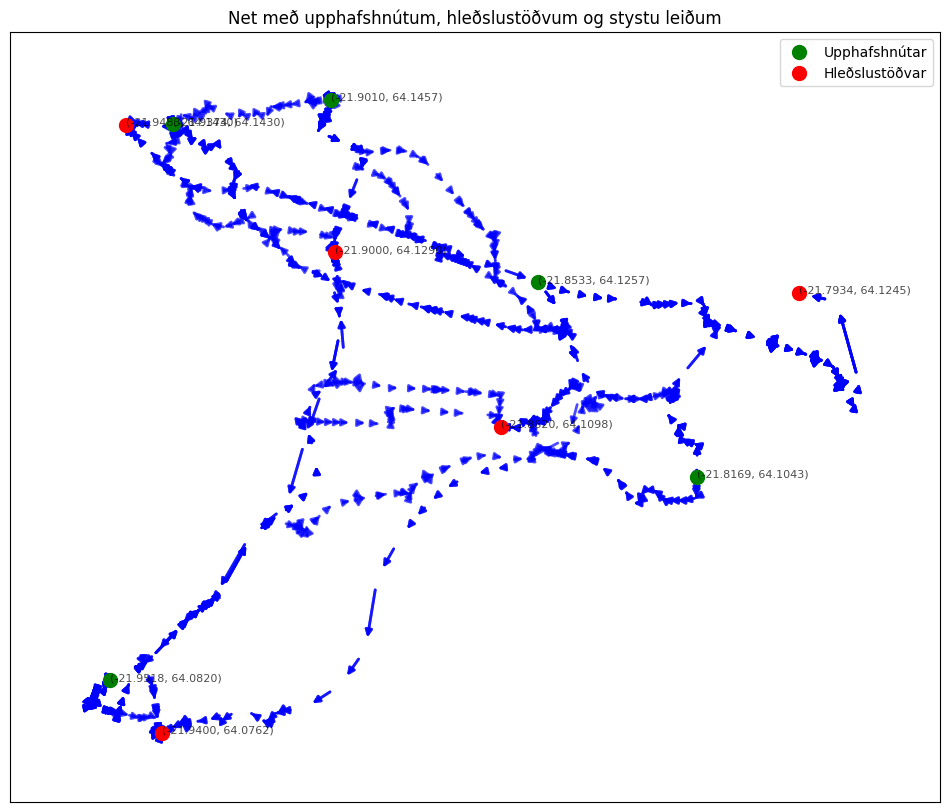

In [ ]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes with attributes
for _, row in nodes.iterrows():
    G.add_node(row["osmid"], x=row["x"], y=row["y"], primary=row["primary"])

# Add edges with weights
for _, row in edges.iterrows():
    G.add_edge(row["u"], row["v"], weight=row["length"])

# Add nodes with positions
pos = {row["osmid"]: (row["x"], row["y"]) for _, row in nodes.iterrows()}

# Collect edges that are part of the shortest paths
shortest_path_edges = []
for _, row in shortest_path_five.iterrows():
    start_node = row["start_node"]
    charging_station = row["charging_station"]
    distance = row["distance"]

    if distance != float("inf"):  # Only include if a path exists
        path = nx.shortest_path(G, source=start_node, target=charging_station, weight="weight") # hér er stysta leið reiknuð með nx pakkanum...
        shortest_path_edges.extend(list(zip(path[:-1], path[1:])))  # Add edges from the path

# Plot the graph
plt.figure(figsize=(12, 10))

# Highlight start nodes
nx.draw_networkx_nodes(
    G, pos, nodelist=five_nodes, node_color="green", node_size=100, label="Upphafshnútar"
)

# Highlight charging stations
nx.draw_networkx_nodes(
    G, pos, nodelist=charging_stations, node_color="red", node_size=100, label="Hleðslustöðvar"
)

# Draw only the edges in the shortest paths
nx.draw_networkx_edges(
    G, pos, edgelist=shortest_path_edges, edge_color="blue", width=2, alpha=0.7
)

# Annotate only the start nodes and charging stations
for node in five_nodes + charging_stations:
    x, y = pos[node]
    plt.text(x, y, f"({x:.4f}, {y:.4f})", fontsize=8, color="black", alpha=0.7)

# Add legend and title
plt.legend()
plt.title("Net með upphafshnútum, hleðslustöðvum og stystu leiðum")
plt.show()

In [ ]:
import folium

def plot_map_with_paths(G, starting_nodes, shortest_paths, stations, nodes):

    start_coords = nodes[nodes["osmid"].isin(starting_nodes)][["x", "y"]]

    station_coords = nodes[nodes["osmid"].isin(stations)][["x", "y"]]

    # Setjum miðju kortsins á meðaltal hnitanna
    map_center = [station_coords["y"].mean(), station_coords["x"].mean()]
    folium_map = folium.Map(location=map_center, zoom_start=13)

    # Merkjum upphafspunktana á kortið
    for _, row in start_coords.iterrows():
        folium.Marker(
            location=[row["y"], row["x"]],
            popup=f"Start Node ID: {row.name}",
            icon=folium.Icon(color="green", icon="play", prefix="fa"),
        ).add_to(folium_map)

    # Merkjum hleðslustöðvarnar á kortið
    for _, row in station_coords.iterrows():
        folium.Marker(
            location=[row["y"], row["x"]],
            popup=f"Station ID: {row.name}",
            icon=folium.Icon(color="blue", icon="charging-station", prefix="fa"),
        ).add_to(folium_map)

    # Teiknum stystu leiðirnar á kortið
    #for path in shortest_paths:
    #    path_coords = [
    #        (nodes.loc[nodes["osmid"] == node, "y"].values[0],
    #         nodes.loc[nodes["osmid"] == node, "x"].values[0])
    #        for node in path
    #    ]
    #    folium.PolyLine(
    #        locations=path_coords,
    #        color="red",
    #        weight=3,
     #       opacity=0.7,
    #    ).add_to(folium_map)
        
    return folium_map


In [9]:
map = plot_map_with_paths(five_nodes, shortest_path_five, charging_stations, nodes)
map

### 4. Tímamælingar (⋆)

Mælið tímann sem reikniritið dijkstra tekur að reikna allar fjarlægðir í netinu með fimm hleðslustöðvum.

In [ ]:
# tekur ca 16 mínútur
shortest_path_all_slow = shortest_path_to_charging_station(nodes, edges, charging_stations, nodes["osmid"].tolist())

In [59]:
import time

start_time = time.time()

shortest_path_all_fast = shortest_path_to_charging_station_faster(nodes, edges, charging_stations, nodes["osmid"].tolist())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Reiknirit Djikstra tók: {elapsed_time:.4f} sekúndur")

Reiknirit Djikstra tók: 0.6569 sekúndur


### 5. A* Reikniritið (⋆⋆)
Útfærið A⋆ reikniritið sem tekur inn lista af lokahnútum og reiknar fjarlægðir frá öllum hnútum í netinu. Sem neðra mat á fjarlægð á milli hnútanna má taka d(u, v) =p(xu − xv )2 + (yu − yv )2, þ.e. beina loftlínu milli punktanna. Mælið tíma og berið saman við reiknirit Dijkstra.

In [78]:
import heapq
import math



# fall sem tekur inn net og lista af hleðslustöðvum i því neti og skilar lista af öllum hnútum og styðstu leið þeirra til hleðslustöðvar
def shortest_paths_to_charging_stations_using_Astar(G, charging_stations):
    """Reiknirit sem finnur styðstu leið alla punkta til hleðslustöðvar"""

    heuristic = {
        node: min(math.sqrt((G.nodes[node]["x"] - G.nodes[cs]["x"])**2 + (G.nodes[node]["y"] - G.nodes[cs]["y"])**2) 
               for cs in charging_stations)
        for node in G.nodes
    }

    results = {} # geymir styðstu leið fyrir hvern punkt

    for start in G.nodes:  # Keyrum A* fyrir hvern einasta punkt
        # smá setup
        open_set = [(0, start)]  # setjum inn upphafspunkt með ekkert weight
        g_score = {n: float('inf') for n in G.nodes} # látum g gildi alla punkta verða óendanleg
        g_score[start] = 0 # upphafspunkturinn tekur engan tíma til að komast í

        # ítrum í gegnum priority queue-ið
        while open_set:
            _, current = heapq.heappop(open_set) # fáum léttasta hnútinn

            if current in charging_stations:  # ef við erum stödd á hleðslustöð
                results[start] = g_score[current] # setjum inn styðstu vegalengdina fyrir upphafspunktinn í results
                break  # þurfum ekki að gera neitt meira því hleðslustöð fannst

            for neighbor in G.neighbors(current): # ítrum í gegnum nágranna punktsins sem við völdum
                weight = G[current][neighbor]["weight"] # finnum lengd milli nágranna punktsins og punktsins sem við völdum
                tentative_g = g_score[current] + weight # lengd frá upphafspunkt í þennan nágranna ef notað er besta leiðin til valda punktsins

                if tentative_g < g_score[neighbor]: # kíkjum hvort að nýja lengdin sé styttri en sú sem nágranninn hefur nú þegar
                    g_score[neighbor] = tentative_g # breytum g gildi nágrannans
                    f_score = tentative_g + heuristic[neighbor] # reiknum f gildi hans
                    heapq.heappush(open_set, (f_score, neighbor)) # setjum nágrannan með f gildinu hans í priority queue-ið okkar

        # gerist eftir að while lykjan er búin
        if start not in results:  # þetta gerist ef hleðslustöð var aldrei fundin
            results[start] = float('inf') # segjum að lengdin sé óendanleg

    return results

In [109]:
import heapq
import math
from collections import defaultdict

def shortest_paths_to_charging_stations_using_Astar_faster(G, charging_stations, nodes):
    """Reiknirit sem finnur styðstu leið allra punkta til hleðslustöðvar"""
    
    # þetta er mjög svipað og A* fyrir ofan nema í staðinn fyrir að fara í gegnum hvern hnút og finna lengdina
    # þá er farið út frá hleðslustöðvunum í alla hnúta og þá er ekki verið að endur reikna neitt
    # ætla ekki að gera comments fyrir þetta strax því þetta er mjög svipað hinu 

    # Build a coordinate lookup from DataFrame
    coords = nodes.set_index('osmid')[['x', 'y']].to_dict('index')

    heuristic = {
        n: min(math.sqrt((coords[n]["x"] - coords[cs]["x"])**2 + (coords[n]["y"] - coords[cs]["y"])**2) 
               for cs in charging_stations)
        for n in G
    }

    open_set = []
    g_score = defaultdict(lambda: float('inf'))

    for cs in charging_stations:
        g_score[cs] = 0
        heapq.heappush(open_set, (heuristic[cs], cs))

    while open_set:
        _, current = heapq.heappop(open_set)

        for neighbor, weight in G.get(current, {}).items():
            tentative_g = g_score[current] + weight

            if tentative_g < g_score[neighbor]:
                g_score[neighbor] = tentative_g
                f_score = tentative_g + heuristic[neighbor]
                heapq.heappush(open_set, (f_score, neighbor))

    return dict(g_score)


In [81]:
# samanburður á A-star og Dijkstra
import time

G = make_graph(nodes, edges)

charging_stations = [12885876, 111456955, 14586813, 26471955, 34187360]

start_time = time.time()

results = shortest_paths_to_charging_stations_using_Astar_faster(G, charging_stations)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Reiknirit A-star tók: {elapsed_time:.4f} sekúndur")
# Reiknirit A-star tók: 0.1827 sekúndur

start_time = time.time()

shortest_path_all_slow = shortest_path_to_charging_station_faster(nodes, edges, charging_stations, nodes["osmid"].tolist())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Reiknirit Djikstra tók: {elapsed_time:.4f} sekúndur")
# Reiknirit Djikstra tók: 3.5279 sekúndur

Reiknirit A-star tók: 0.0466 sekúndur
Reiknirit Djikstra tók: 0.6539 sekúndur


### 6. Staðsetning hleðslustöðva (⋆⋆)

Ef við setjum k hleðslustöðvar í hnúta v1, . . . , vk þá látum við markfallið vera
F (v1, . . . , vk) = X
u∈V
min
i=1,...,k d(u, vi)
þ.e. fyrir hvern hnút í netinu reiknum við stystu fjarlægð frá honum til næstu hleðslustöðvar
og leggjum saman yfir alla hnúta í netinu. Finnið bestu lausn fyrir k = 1, með því að prófa alla hnúta sem hægt er að setja
hleðslustöð í og veljið þann sem gefur minnsta markfall. Athugið að eingöngu þeir hnútar
sem eru merktir sem primary geta verið hleðslustöðvar.

In [82]:
def average_distance(results):
    """reiknum meðal lengd hnúta frá hleðslustöð"""
    penalty_value = 10**7 # þurfum að taka með að sumir hnútar geta ekki náð í hleðslustöð svo þá er lengdin inf en það eyðileggur average-ið
    distances = [
        dist if dist != float('inf') else penalty_value # svo í staðinn breytum við inf lengdum í stóra tölu
        for dist in results.values() # ( það virkar ekki að taka út allar inf tölur því þá erum við ekki að fá raunverulegt average )
        ]
    if not distances:  # Ef enginn hnútur nær til hleðslustöðvar
        return None # skilum við bara None

    return sum(distances) / len(distances) # samtals lengd / magn hnúta

In [ ]:
possible_charging_stations = nodes[nodes["primary"]]["osmid"].tolist()
print(f'Fjöldi mögulegra hleðslustöðva: {len(possible_charging_stations)}')

start_time = time.time()

lowest_dist = float('inf')
best_charger = None
for charging_station in possible_charging_stations:
    results = shortest_paths_to_charging_stations_using_Astar_faster(G, [charging_station])
    avrg_dist = average_distance(results)
    print(f"Hleðslustöð: {charging_station}, meðalvegalengd (m): {avrg_dist}")
    if avrg_dist is not None and avrg_dist < lowest_dist:
        lowest_dist = avrg_dist
        best_charger = charging_station

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Þetta tók: {elapsed_time:.4f} sekúndur")
print(f'Besta hleðslustöð er: {best_charger} með meðalvegalengdina: {lowest_dist}')

fjöldi mögulega hleðslustöðva: 1829
Charging station: 12885876, average distance: 18014.797861674375
Charging station: 12885924, average distance: 18583.180886646955
Charging station: 12885930, average distance: 18018.115567496887
Charging station: 12885952, average distance: 18024.564171923663
Charging station: 12885979, average distance: 18053.604954517214
Charging station: 12885991, average distance: 18030.995664590562
Charging station: 12886003, average distance: 18589.721348447238
Charging station: 12886027, average distance: 18039.603056531847
Charging station: 14581636, average distance: 20259.80085862701
Charging station: 14581771, average distance: 20295.582528515675
Charging station: 14581824, average distance: 20213.7256088593
Charging station: 14581900, average distance: 20234.87800079587
Charging station: 14581950, average distance: 20240.715425640534
Charging station: 14581956, average distance: 19585.926535498565
Charging station: 14581975, average distance: 20269.438477

Besta hleðslustöð er: 560670782 með meðalvegalengdina: 15633.953016765261 - þessi staðsetning er á miðju höfuðborgarsvæðinu, þar sem Reykjanesbraut og Breiðholtsbraut mætast.

### 7. Gráðug reiknirit (⋆⋆)

Útfærið gráðugt reiknirit sem leitar að bestu lausn fyrir k = 2, . . . , 10 með því að leysa
vandamálið fyrir k−1 hleðslustöðvum og bæta þá við þann hnút sem gefur minnsta markfall,
miðað við að ekki sé hægt að breyta v1, . . . , vk−1.
Sýnið á korti hvaða hleðslustöðvar eru valdar fyrir k = 10 og mælið tímann sem reikniritið
tekur.

In [85]:
start_time = time.time()

best_stations = []
results = None

for k in range(1, 11):  # k frá 1 til 10
    print(f"Finna stöð nr {k}...")
    lowest_avg = float('inf')
    best_candidate = None

    for candidate in possible_charging_stations:
        if candidate in best_stations:
            continue  # sleppum þeim sem eru nú þegar valdar

        trial_stations = best_stations + [candidate]
        trial_results = shortest_paths_to_charging_stations_using_Astar_faster(G, trial_stations)
        trial_avg = average_distance(trial_results)

        if trial_avg < lowest_avg:
            lowest_avg = trial_avg
            best_candidate = candidate

    best_stations.append(best_candidate)

end_time = time.time()
elapsed_time = end_time - start_time

print("Bestu hleðslustöðvarnar:")
for i, cs in enumerate(best_stations, 1):
    print(f"{i}. {cs}")
print(f"Þetta tók: {elapsed_time:.4f} sekúndur")

# fjöldi mögulega hleðslustöðva: 1829
# Finna stöð nr 1...
# Finna stöð nr 2...
# Finna stöð nr 3...
# Finna stöð nr 4...
# Finna stöð nr 5...
# Finna stöð nr 6...
# Finna stöð nr 7...
# Finna stöð nr 8...
# Finna stöð nr 9...
# Finna stöð nr 10...
# Bestu hleðslustöðvarnar:
# 1. 560670782
# 2. 5541083892
# 3. 10740089234
# 4. 470316420
# 5. 251765349
# 6. 8138139106
# 7. 1420012506
# 8. 111474147
# 9. 2948755310
# 10. 252165202
# Þetta tók: 2360.9228 sekúndur


Finna stöð nr 1...
Finna stöð nr 2...
Finna stöð nr 3...
Finna stöð nr 4...
Finna stöð nr 5...
Finna stöð nr 6...
Finna stöð nr 7...
Finna stöð nr 8...
Finna stöð nr 9...
Finna stöð nr 10...
Bestu hleðslustöðvarnar:
1. 560670782
2. 5541083892
3. 10740089234
4. 470316420
5. 251765349
6. 8138139106
7. 1420012506
8. 111474147
9. 2948755310
10. 252165202
Þetta tók: 954.4251 sekúndur


In [86]:
import folium

def plot_charging_stations_on_map(best_stations, nodes):
    """Teiknar hleðslustöðvar á kort"""
    
    # Náum í hnit bestu hleðslustöðvanna
    station_coords = nodes[nodes["osmid"].isin(best_stations)][["x", "y"]]

    # Setjum miðju kortsins á meðaltal hnitanna
    map_center = [station_coords["y"].mean(), station_coords["x"].mean()]
    folium_map = folium.Map(location=map_center, zoom_start=13)

    # Merkjum hleðslustöðvarnar á kortinu
    for _, row in station_coords.iterrows():
        folium.Marker(
            location=[row["y"], row["x"]],
            popup=f"Station ID: {row.name}",
            icon=folium.Icon(color="blue", icon="info-sign"),
        ).add_to(folium_map)
        
    return folium_map

In [87]:
map = plot_charging_stations_on_map(best_stations, nodes)
map

### 8. Skárri gráðug reiknirit (⋆⋆)

Gráðuga reikniritið á það til að mála sig út í horn með því að velja lélegan fyrsta hnút.
Breytið leitinni þannig að þið veljið handahófskenndan fyrsta hnút og farið endurkvæmt í
tilfellin k = 2, . . . , 10. Í hverju undirtilfelli finnið þið 2 bestu hnútana sem koma til greina
en eru langt frá hvor öðrum og prófið endurkvæmt alla möguleika. Haldið utan um bestu
lausnina sem finnst fyrir nokkur hanndahófskennda upphafspunkta og sýnið bestu lausn á
korti. Hve mikinn tíma tekur reikniritið ykkar?

In [133]:
import random
import math

def euclidean_distance_direct(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def find_farthest_nodes(nodes):
    """Finnur þá hnúta sem eru lengst frá hverjum öðrum"""
    max_distance = -1
    farthest_pair = (None, None)

    for i, node1 in nodes.iterrows():
        for j, node2 in nodes.iterrows():
            if i >= j:  # Avoid duplicate pairs and self-comparisons
                continue

            # Calculate the Euclidean distance directly from x and y coordinates
            dist = euclidean_distance_direct(node1["x"], node1["y"], node2["x"], node2["y"])

            # Update the farthest pair if the distance is greater
            if dist > max_distance:
                max_distance = dist
                farthest_pair = (node1["osmid"], node2["osmid"])
                
    return farthest_pair

In [115]:
def find_two_possible_nodes(G, nodes, best_stations, remaining_nodes):
    lowest_avg = float('inf')

    # Finnum fyrst fyrsta hnútinn sem er besti möguleikinn
    for candidate in remaining_nodes:
        trial_stations = best_stations + [candidate]
        trial_results = shortest_paths_to_charging_stations_using_Astar_faster(G, trial_stations, nodes) # nodes þarf að vera dataframe
        trial_avg = average_distance(trial_results)

        if trial_avg < lowest_avg:
            lowest_avg = trial_avg
            best_candidate1 = candidate

    remaining_nodes.remove(best_candidate1)

    # Finnum svo hnút sem er næst-bestur en amk 10.000 metra frá fyrsta hnútnum sem við völdum
    # Remove nodes from remaining_nodes by running dijkstra and picking the nodes that are closest to the best_candidate1
    # The threshold is 10.000 meters
    threshold = 10000
    distances, prev = dijkstra(G, best_candidate1) # kannski breyta seinna þannig reiknum bara frá primary hnútum
    closest_nodes = [node for node, dist in distances.items() if dist < threshold and node not in best_stations]
    furthest_nodes = remaining_nodes.remove(closest_nodes)

    lowest_avg = float('inf')

    for candidate in furthest_nodes:
        trial_stations = best_stations + [candidate]
        trial_results = shortest_paths_to_charging_stations_using_Astar_faster(G, trial_stations, nodes)
        trial_avg = average_distance(trial_results)

        if trial_avg < lowest_avg:
            lowest_avg = trial_avg
            best_candidate2 = candidate
            
    return best_candidate1, best_candidate2


In [116]:
import random

def recursive_selection(G, nodes, possible_charging_stations, k=10, best_stations=None):
    """Velur handahófskennt fyrsta hnútinn og svo endurkvæmt hina k-1 hnútana. 
       Í hverju undirverkefni eru tveir bestu hnútarnir sem koma til greina en 
       eru langt frá hvor öðrum fundnir og allir möguleikar prófaðir endurkvæmt.
       
       Inntak: 
       nodes: listi af öllum mögulegum hnútum
       pos: hnit hnútanna
       k: fjöldi hnúta sem á að velja
       selected_nodes: listi af nú þegar völdum hnútum

       setja í priority queue

       hvora lausnina ættum við að velja?
       
       Úttak: 
       listi af völdum hnútum
    """

    if best_stations is None:
        best_stations = []

    # Grunntilfelli: stoppum þegar k hnútar hafa verið valdir
    if len(best_stations) == k:
        return best_stations

    # Ef það er ekki búið að velja fyrsta hnútinn, veljum við hann handahófskennt
    if not best_stations:
        first_node = random.choice(possible_charging_stations["osmid"].tolist())
        best_stations.append(first_node)

    print(f"Finna tvo möguleika fyrir stöð nr {k}...")
    # Finnum tvo mögulega hnúta sem eru langt frá hverjum öðrum
    remaining_nodes = possible_charging_stations[~possible_charging_stations["osmid"].isin(best_stations)]
    candidate1, candidate2 = find_two_possible_nodes(G, nodes, best_stations, remaining_nodes)

    option1 = recursive_selection(G, nodes, possible_charging_stations, k-1, best_stations + [candidate1])
    option2 = recursive_selection(G, nodes, possible_charging_stations, k-1, best_stations + [candidate2])

    option1_avg = average_distance(shortest_paths_to_charging_stations_using_Astar_faster(G, option1, nodes))
    option2_avg = average_distance(shortest_paths_to_charging_stations_using_Astar_faster(G, option2, nodes))

    if option1_avg < option2_avg:
        best_stations = option1
        return best_stations
    else:  
        best_stations = option2
        return best_stations

In [117]:
possible_charging_stations_small = small_nodes[small_nodes["primary"]]

two_best_stations = recursive_selection(G_small_dict, small_nodes, possible_charging_stations_small, k=2, best_stations=None)
print("Bestu hleðslustöðvarnar (handahófskennt val):")
for cs in enumerate(two_best_stations, 1):
    print(f"{cs}")

Finna tvo möguleika fyrir stöð nr 2...


KeyError: 'osmid'

In [121]:
possible_charging_stations_small = small_nodes[small_nodes["primary"]]
best_stations = possible_charging_stations_small[:1]

remaining_nodes = possible_charging_stations_small[~possible_charging_stations_small["osmid"].isin(best_stations)]
remaining_nodes

,osmid,x,y,primary
1738,252743977,-21.934162,64.088534,True
1742,252744087,-21.934460,64.088544,True
6753,1194972614,-21.934915,64.088324,True
10714,10799990311,-21.933635,64.088356,True
10715,10799990319,-21.934297,64.088471,True
10717,10799990340,-21.934336,64.088600,True
10719,10799990350,-21.933701,64.088735,True


### 9. Nákvæm lausn fyrir k = 10 (⋆ ⋆ ⋆)

Finnið bestu lausn fyrir k = 10 með því að setja vandamálið upp sem heiltölubestunarverkefni (e. integer linear program) og leysa það með því að nota pakka á borð við Gurobi eða
OR-tools. Athugið að verkefnið gæti verið of stórt fyrir þessa pakka. Nýtið ykkur götur í hverfum eru oft teng við primary hnúta í gegnum einn veg, þá er hægt að einfalda netið með því að skipta þessum hverfum út fyrir einn hnút sem tengir sameiginlegan primary hnút. Þessa leggi er hægt að finna með DFS. Sýnið bestu lausnina á korti og mælið tímann sem
heiltölubestunarverkefnið tekur.
